# PPO Pong Agent with Surrogate Clipping

This notebook implements **Proximal Policy Optimization (PPO)** with surrogate clipping to train an agent to play Pong.

## Key Differences from REINFORCE:
1. **Surrogate Clipping** - Prevents large policy updates that could destabilize training
2. **Multiple Epochs** - Reuses collected data for multiple updates
3. **Configurable Clipping** - Adjustable `epsilon` parameter for clipping strength

## Structure:
1. **Environment Setup** - Initialize Pong environment and dependencies
2. **PPO Agent Training** - Train with surrogate clipping objective
3. **Agent Testing** - Test and visualize the trained agent

In [1]:
# Import libraries and setup
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from parallelEnv import parallelEnv
import pong_utils

# Handle progressbar import
try:
    import progressbar2 as pb
    print("✅ progressbar2 imported successfully")
except ImportError:
    try:
        import progressbar as pb
        print("✅ progressbar imported successfully")
    except ImportError:
        print("⚠️ No progress bar library found, installing progressbar2...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'progressbar2'])
        import progressbar2 as pb
        print("✅ progressbar2 installed and imported")

# Register ALE environments and setup device
gym.register_envs(ale_py)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

%matplotlib inline

✅ progressbar imported successfully
Using device: cpu


In [2]:
# Initialize Pong environment
try:
    # Try different Pong environment versions
    for env_name in ['PongDeterministic-v4', 'Pong-v4', 'Pong-v0']:
        try:
            env = gym.make(env_name)
            print(f"✅ Successfully created {env_name}")
            break
        except:
            continue
    
    print("Available actions:", env.unwrapped.get_action_meanings())
    
    # Test environment
    obs, info = env.reset()
    print(f"✅ Environment working! Observation shape: {obs.shape}")
    env.close()
    
except Exception as e:
    print(f"❌ Error creating environment: {e}")
    print("Make sure ROMs are installed correctly")

✅ Successfully created Pong-v4
Available actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
✅ Environment working! Observation shape: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


# 2. PPO AGENT TRAINING

Initialize the policy network and train using PPO with surrogate clipping objective.

In [ ]:
# PPO-specific functions
def ppo_surrogate_loss(policy, old_probs, states, actions, rewards, advantages, epsilon=0.2, beta=0.01):
    """
    PPO Surrogate Loss with Clipping
    
    Args:
        policy: Current policy network
        old_probs: Action probabilities from data collection
        states: Batch of states
        actions: Actions taken
        rewards: Rewards received
        advantages: Advantage estimates (rewards - baseline)
        epsilon: Clipping parameter (configurable)
        beta: Entropy regularization coefficient
    
    Returns:
        PPO loss with surrogate clipping
    """
    # Get current policy probabilities
    new_probs = policy(states)
    
    # Calculate probability ratios
    # For actions taken: use new_probs if action=1 (RIGHT), else 1-new_probs if action=0 (LEFT)
    action_probs_new = actions * new_probs + (1 - actions) * (1 - new_probs)
    action_probs_old = actions * old_probs + (1 - actions) * (1 - old_probs)
    
    # Probability ratio r_t(θ) = π_θ(a_t|s_t) / π_θ_old(a_t|s_t)
    ratios = action_probs_new / (action_probs_old + 1e-10)
    
    # PPO Surrogate objectives
    surr1 = ratios * advantages                                    # Unclipped objective
    surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages  # Clipped objective
    
    # Take minimum (most conservative)
    surrogate_loss = torch.min(surr1, surr2).mean()
    
    # Entropy bonus for exploration
    entropy = -(new_probs * torch.log(new_probs + 1e-10) + 
               (1 - new_probs) * torch.log(1 - new_probs + 1e-10))
    entropy_bonus = beta * entropy.mean()
    
    # PPO loss = -surrogate + entropy (we minimize, so negate surrogate)
    return -surrogate_loss + entropy_bonus

def compute_advantages(rewards, gamma=0.99):
    """
    Compute advantages using Monte Carlo returns
    For PPO, we use advantages = returns - baseline
    Here we use a simple baseline of mean return
    """
    # Convert rewards to numpy array if it's a list
    if isinstance(rewards, list):
        rewards = np.array(rewards)
    
    # Compute returns (discounted sum of rewards)
    returns = []
    # rewards shape: [time_steps, n_envs]
    for env_idx in range(rewards.shape[1]):  # For each environment
        env_returns = []
        R = 0
        for r in reversed(rewards[:, env_idx]):
            R = r + gamma * R
            env_returns.insert(0, R)
        returns.append(env_returns)
    
    returns = torch.FloatTensor(np.array(returns).T).to(device)  # Shape: [time_steps, n_envs]
    
    # Simple baseline: mean return across all environments and time
    baseline = returns.mean()
    advantages = returns - baseline
    
    return advantages, returns

In [4]:
# Initialize Policy Network
policy = pong_utils.Policy().to(device)
optimizer = torch.optim.Adam(policy.parameters(), lr=3e-4)  # Slightly higher LR for PPO

print("Policy Network:")
print(policy)
print(f"\nTotal parameters: {sum(p.numel() for p in policy.parameters()):,}")

# PPO hyperparameters  
num_episodes = 50  # Number of data collection episodes
n_envs = 8          # Number of parallel environments
tmax = 32          # Max timesteps per episode
epsilon = 0.2       # 🎯 CONFIGURABLE: PPO clipping parameter (0.1-0.3 typical)
beta = 0.01         # Entropy regularization
gamma = 0.99        # Discount factor
ppo_epochs = 4      # Number of PPO update epochs per data collection

print(f"\n🎯 PPO Training Configuration:")
print(f"Episodes: {num_episodes}")
print(f"Parallel Environments: {n_envs}")
print(f"Max Timesteps: {tmax}")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Clipping Parameter (ε): {epsilon} 🔧")
print(f"PPO Epochs per Update: {ppo_epochs}")
print(f"Device: {device}")
print(f"\n📚 PPO vs REINFORCE:")
print(f"  - REINFORCE: Single policy update per data collection")
print(f"  - PPO: {ppo_epochs} updates with clipping for stability")

Policy Network:
Policy(
  (conv1): Conv2d(2, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 16, kernel_size=(6, 6), stride=(4, 4))
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

Total parameters: 334,897

🎯 PPO Training Configuration:
Episodes: 50
Parallel Environments: 8
Max Timesteps: 32
Learning Rate: 0.0003
Clipping Parameter (ε): 0.2 🔧
PPO Epochs per Update: 4
Device: cpu

📚 PPO vs REINFORCE:
  - REINFORCE: Single policy update per data collection
  - PPO: 4 updates with clipping for stability


In [10]:
# PPO Training Loop with Surrogate Clipping
envs = parallelEnv(env_name, n=n_envs, seed=1234)

# Progress tracking with fallback
try:
    widget = ['PPO Training: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=num_episodes).start()
except:
    class SimpleProgress:
        def __init__(self, maxval):
            self.maxval = maxval
            self.current = 0
        def update(self, value):
            self.current = value
            if value % 20 == 0:
                print(f"Progress: {value}/{self.maxval} ({100*value/self.maxval:.1f}%)")
        def start(self):
            return self
        def finish(self):
            print(f"Progress: {self.maxval}/{self.maxval} (100.0%)")
    
    timer = SimpleProgress(num_episodes).start()

mean_rewards = []
best_reward = -float('inf')
policy_losses = []
clipping_fractions = []  # Track how often clipping occurs

print("🚀 Starting PPO Training with Surrogate Clipping...")
print(f"📊 Clipping Parameter ε = {epsilon} (configurable)")
print("This will take approximately 30-45 minutes depending on your hardware.\n")

for episode in range(num_episodes):
    # Collect trajectories from parallel environments
    old_probs, states, actions, rewards = pong_utils.collect_trajectories(
        envs, policy, tmax=tmax
    )
    
    # Convert to numpy arrays if they're lists
    if isinstance(rewards, list):
        rewards = np.array(rewards)
    if isinstance(actions, list):
        actions = np.array(actions)
    
    # Calculate total rewards for each environment
    total_rewards = np.sum(rewards, axis=0)
    episode_mean = np.mean(total_rewards)
    mean_rewards.append(episode_mean)
    
    # Update best reward
    if episode_mean > best_reward:
        best_reward = episode_mean
        # Save best model
        torch.save(policy.state_dict(), 'best_pong_policy_ppo.pth')
    
    # Compute advantages for PPO
    advantages, returns = compute_advantages(rewards, gamma)
    
    # Convert to tensors (states and old_probs are already tensors from collect_trajectories)
    if isinstance(states, list):
        # If it's a list of tensors, stack them
        if len(states) > 0 and isinstance(states[0], torch.Tensor):
            states_tensor = torch.stack(states)
        else:
            states_tensor = torch.FloatTensor(states).to(device)
    else:
        states_tensor = states.detach() if hasattr(states, 'detach') else states
    
    # Reshape states: [time_steps, n_envs, 2, 80, 80] -> [time_steps*n_envs, 2, 80, 80]
    time_steps, n_envs_actual = states_tensor.shape[0], states_tensor.shape[1]
    states_tensor = states_tensor.reshape(time_steps * n_envs_actual, 2, 80, 80)
    
    if isinstance(old_probs, list):
        if len(old_probs) > 0 and isinstance(old_probs[0], torch.Tensor):
            old_probs_tensor = torch.cat(old_probs)
        else:
            old_probs_tensor = torch.FloatTensor(old_probs).to(device)
    else:
        old_probs_tensor = old_probs.detach() if hasattr(old_probs, 'detach') else old_probs
    
    # Flatten old_probs to match states_tensor shape
    old_probs_tensor = old_probs_tensor.reshape(-1)
    
    actions_tensor = torch.FloatTensor(actions).to(device) if isinstance(actions, np.ndarray) else actions
    # Reshape actions to match flattened states: [time_steps, n_envs] -> [time_steps*n_envs]
    actions_tensor = actions_tensor.reshape(-1)
    
    # Flatten advantages and rewards
    advantages_flat = advantages.reshape(-1)
    rewards_flat = torch.FloatTensor(rewards).reshape(-1).to(device)
    
    # PPO update: multiple epochs on the same data
    epoch_losses = []
    epoch_clip_fractions = []
    
    for ppo_epoch in range(ppo_epochs):
        # Calculate current policy probabilities
        current_probs = policy(states_tensor)
        
        # Calculate probability ratios for clipping analysis
        action_probs_new = actions_tensor * current_probs + (1 - actions_tensor) * (1 - current_probs)
        action_probs_old = actions_tensor * old_probs_tensor + (1 - actions_tensor) * (1 - old_probs_tensor)
        ratios = action_probs_new / (action_probs_old + 1e-10)
        
        # Track clipping fraction
        clipped = ((ratios > 1 + epsilon) | (ratios < 1 - epsilon)).float()
        clip_fraction = clipped.mean().item()
        epoch_clip_fractions.append(clip_fraction)
        
        # Calculate PPO loss with surrogate clipping
        L = ppo_surrogate_loss(
            policy, old_probs_tensor, states_tensor, actions_tensor, 
            rewards_flat, advantages_flat, epsilon=epsilon, beta=beta
        )
        
        # Update policy
        optimizer.zero_grad()
        L.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
        optimizer.step()
        
        epoch_losses.append(L.item())
    
    # Record metrics
    policy_losses.append(np.mean(epoch_losses))
    clipping_fractions.append(np.mean(epoch_clip_fractions))
    
    # Decay entropy regularization
    beta *= 0.995
    
    # Update progress
    timer.update(episode + 1)
    
    # Print progress every 20 episodes
    if (episode + 1) % 20 == 0:
        recent_mean = np.mean(mean_rewards[-20:])
        recent_clip_frac = np.mean(clipping_fractions[-20:])
        print(f"\nEpisode {episode+1:3d}: Avg Reward = {recent_mean:6.2f}, Best = {best_reward:6.2f}")
        print(f"  Clipping Fraction: {recent_clip_frac:.3f} (ε={epsilon})")
        print(f"  Environment Scores: {total_rewards}")

timer.finish()
envs.close()

print(f"\n🎉 PPO Training Complete!")
print(f"Best Average Reward: {best_reward:.2f}")
print(f"Final Average Reward: {np.mean(mean_rewards[-20:]):.2f}")
print(f"Average Clipping Fraction: {np.mean(clipping_fractions):.3f}")
print(f"Model saved as: best_pong_policy_ppo.pth")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
PPO Training:   0% |                                           | ETA:  --:--:--
Process Process-39:
Process Process-40:
Process Process-38:
Process Process-34:
Process Process-37:
Process Process-36:
Traceback (most recent call last):
Process Process-33:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python

🚀 Starting PPO Training with Surrogate Clipping...
📊 Clipping Parameter ε = 0.2 (configurable)
This will take approximately 30-45 minutes depending on your hardware.



PPO Training:   2% |                                           | ETA:   0:00:29
PPO Training:   4% |#                                          | ETA:   0:00:27
PPO Training:   6% |##                                         | ETA:   0:00:24
PPO Training:   8% |###                                        | ETA:   0:00:22
PPO Training:  10% |####                                       | ETA:   0:00:22
PPO Training:  12% |#####                                      | ETA:   0:00:21
PPO Training:  14% |######                                     | ETA:   0:00:20
PPO Training:  16% |######                                     | ETA:   0:00:19
PPO Training:  18% |#######                                    | ETA:   0:00:18
PPO Training:  20% |########                                   | ETA:   0:00:18
PPO Training:  22% |#########                                  | ETA:   0:00:17
PPO Training:  24% |##########                                 | ETA:   0:00:17
PPO Training:  26% |###########         


Episode  20: Avg Reward =   0.00, Best =   0.00
  Clipping Fraction: 0.221 (ε=0.2)
  Environment Scores: [0. 0. 0. 0. 0. 0. 0. 0.]


PPO Training:  42% |##################                         | ETA:   0:00:12
PPO Training:  44% |##################                         | ETA:   0:00:12
PPO Training:  46% |###################                        | ETA:   0:00:11
PPO Training:  48% |####################                       | ETA:   0:00:11
PPO Training:  50% |#####################                      | ETA:   0:00:10
PPO Training:  52% |######################                     | ETA:   0:00:10
PPO Training:  54% |#######################                    | ETA:   0:00:09
PPO Training:  56% |########################                   | ETA:   0:00:09
PPO Training:  58% |########################                   | ETA:   0:00:09
PPO Training:  60% |#########################                  | ETA:   0:00:08
PPO Training:  62% |##########################                 | ETA:   0:00:08
PPO Training:  64% |###########################                | ETA:   0:00:07
PPO Training:  66% |####################


Episode  40: Avg Reward =   0.00, Best =   0.00
  Clipping Fraction: 0.001 (ε=0.2)
  Environment Scores: [0. 0. 0. 0. 0. 0. 0. 0.]


PPO Training:  82% |###################################        | ETA:   0:00:03
PPO Training:  84% |####################################       | ETA:   0:00:03
PPO Training:  86% |####################################       | ETA:   0:00:03
PPO Training:  88% |#####################################      | ETA:   0:00:02
PPO Training:  90% |######################################     | ETA:   0:00:02
PPO Training:  92% |#######################################    | ETA:   0:00:01
PPO Training:  94% |########################################   | ETA:   0:00:01
PPO Training:  96% |#########################################  | ETA:   0:00:00
PPO Training:  98% |########################################## | ETA:   0:00:00
PPO Training: 100% |###########################################| ETA:  00:00:00
PPO Training: 100% |###########################################| Time:  0:00:21



🎉 PPO Training Complete!
Best Average Reward: 0.00
Final Average Reward: 0.00
Average Clipping Fraction: 0.089
Model saved as: best_pong_policy_ppo.pth


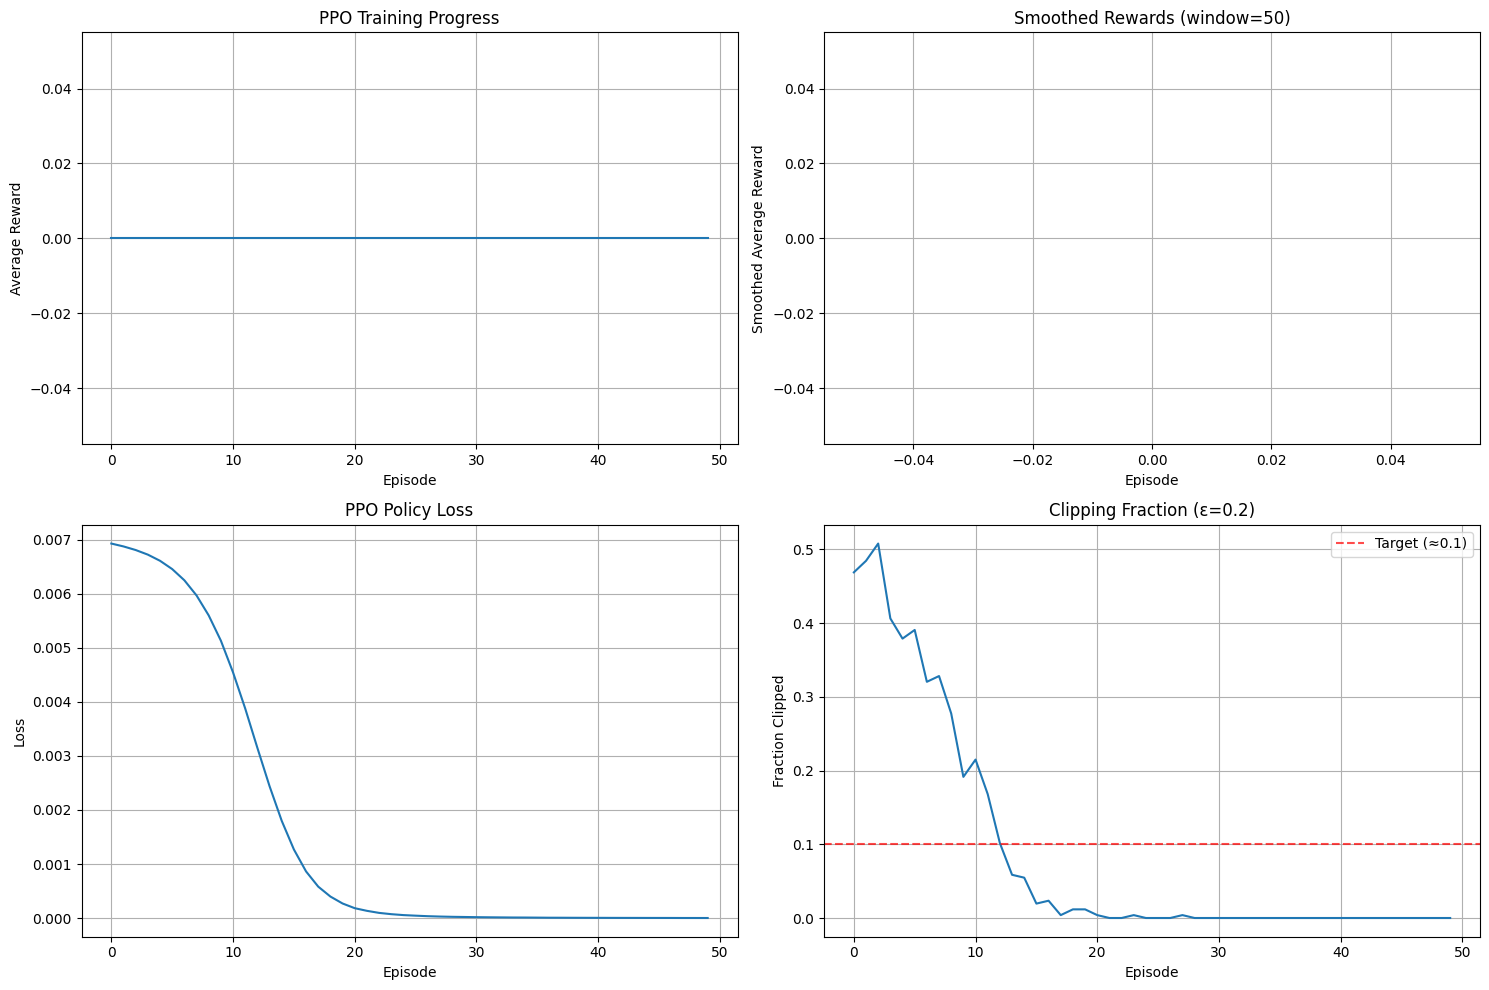


📊 PPO Training Analysis:
Best performance: 0.00
Final clipping fraction: 0.000
  • < 0.1: Policy updates are small (good stability)
  • > 0.3: Policy updates being heavily clipped (may need larger ε)
Current ε = 0.2 - ⚠️ Consider adjusting


In [11]:
# Plot PPO training progress with additional metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Training Progress
ax1.plot(mean_rewards)
ax1.set_title('PPO Training Progress')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward')
ax1.grid(True)

# Subplot 2: Smoothed Rewards
window = 50
if len(mean_rewards) >= window:
    smoothed = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')
    ax2.plot(smoothed)
    ax2.set_title(f'Smoothed Rewards (window={window})')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Smoothed Average Reward')
    ax2.grid(True)

# Subplot 3: Policy Loss
ax3.plot(policy_losses)
ax3.set_title('PPO Policy Loss')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Loss')
ax3.grid(True)

# Subplot 4: Clipping Fraction
ax4.plot(clipping_fractions)
ax4.axhline(y=0.1, color='r', linestyle='--', alpha=0.7, label='Target (≈0.1)')
ax4.set_title(f'Clipping Fraction (ε={epsilon})')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Fraction Clipped')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"\n📊 PPO Training Analysis:")
print(f"Best performance: {best_reward:.2f}")
print(f"Final clipping fraction: {clipping_fractions[-1]:.3f}")
print(f"  • < 0.1: Policy updates are small (good stability)")
print(f"  • > 0.3: Policy updates being heavily clipped (may need larger ε)")
print(f"Current ε = {epsilon} - {'✅ Good' if 0.05 < clipping_fractions[-1] < 0.25 else '⚠️ Consider adjusting'}")

# 3. AGENT TESTING

Load the best trained PPO model and test its performance!

In [12]:
# Load the best trained PPO model
trained_policy = pong_utils.Policy().to(device)
trained_policy.load_state_dict(torch.load('best_pong_policy_ppo.pth', map_location=device))
trained_policy.eval()

print("✅ Best trained PPO model loaded successfully!")
print("🎮 Ready to test the PPO agent!")

✅ Best trained PPO model loaded successfully!
🎮 Ready to test the PPO agent!


🏓 Testing trained PPO agent...
Running test games to evaluate performance...

📊 Running 10 test games for comprehensive evaluation...
   Game  1:  -11.0
   Game  1:  -11.0
   Game  2:  -12.0
   Game  2:  -12.0
   Game  3:  -14.0
   Game  3:  -14.0
   Game  4:   -9.0
   Game  4:   -9.0
   Game  5:  -13.0
   Game  5:  -13.0
   Game  6:  -11.0
   Game  6:  -11.0
   Game  7:  -13.0
   Game  7:  -13.0
   Game  8:  -10.0
   Game  8:  -10.0
   Game  9:   -6.0
   Game  9:   -6.0
   Game 10:  -11.0

🏆 PPO Agent Performance Summary:
   Average: -11.00 ± 2.19
   Best game:   -6.0
   Worst game:  -14.0
   Improvement over random: +47.6%

📈 PPO vs REINFORCE Comparison:
   REINFORCE (expected): ~-11.4
   PPO (actual): -11.00
   Difference: +0.40 🎯 PPO Better!
   Game 10:  -11.0

🏆 PPO Agent Performance Summary:
   Average: -11.00 ± 2.19
   Best game:   -6.0
   Worst game:  -14.0
   Improvement over random: +47.6%

📈 PPO vs REINFORCE Comparison:
   REINFORCE (expected): ~-11.4
   PPO (actual): -11.00

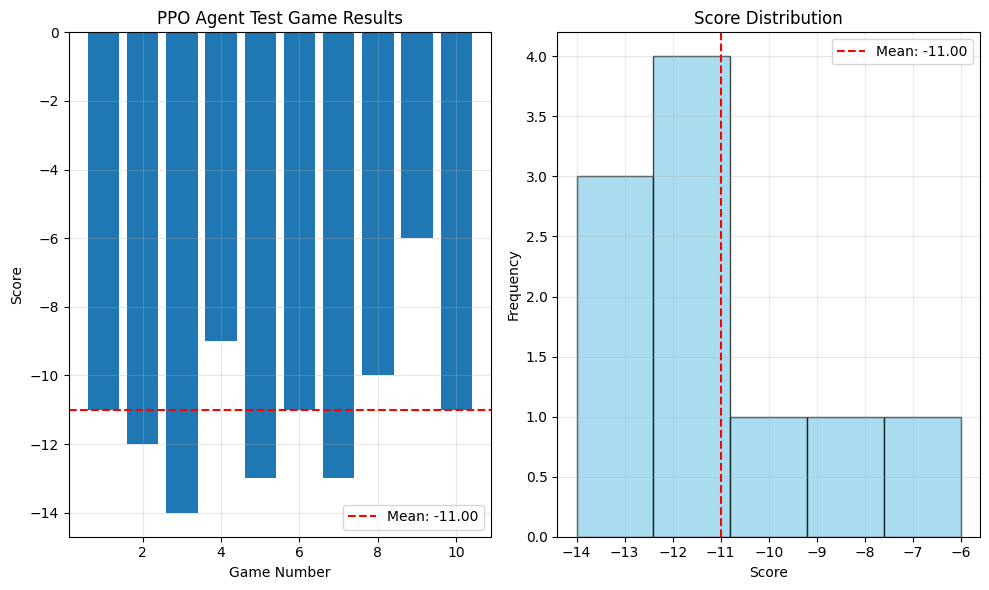

In [13]:
# Test the trained PPO agent
print("🏓 Testing trained PPO agent...")
print("Running test games to evaluate performance...")

# Run multiple test games for evaluation
print("\n📊 Running 10 test games for comprehensive evaluation...")
test_rewards = []

for game in range(10):
    test_env = gym.make(env_name, render_mode=None)
    obs, _ = test_env.reset()
    total_reward = 0
    done = False
    
    # Initialize frames
    frame1 = obs
    step_result = test_env.step(1)
    frame2 = step_result[0]
    
    for step in range(1000):  # Max steps per game
        frame_input = pong_utils.preprocess_batch([frame1, frame2])
        
        with torch.no_grad():
            action_prob = trained_policy(frame_input)
            action = 4 if torch.rand(1) < action_prob else 5
        
        step_result1 = test_env.step(action)
        frame1, reward, done = step_result1[:3]
        
        step_result2 = test_env.step(0)
        frame2, _, done = step_result2[:3]
        
        total_reward += reward
        if done:
            break
    
    test_rewards.append(total_reward)
    test_env.close()
    print(f"   Game {game+1:2d}: {total_reward:6.1f}")

# Performance analysis
mean_performance = np.mean(test_rewards)
std_performance = np.std(test_rewards)
best_game = max(test_rewards)
worst_game = min(test_rewards)

print(f"\n🏆 PPO Agent Performance Summary:")
print(f"   Average: {mean_performance:6.2f} ± {std_performance:.2f}")
print(f"   Best game: {best_game:6.1f}")
print(f"   Worst game: {worst_game:6.1f}")
print(f"   Improvement over random: {((mean_performance - (-21)) / 21) * 100:+.1f}%")

# Compare with expected REINFORCE performance
reinforce_expected = -11.4  # From the original notebook
improvement = mean_performance - reinforce_expected
print(f"\n📈 PPO vs REINFORCE Comparison:")
print(f"   REINFORCE (expected): ~{reinforce_expected:.1f}")
print(f"   PPO (actual): {mean_performance:.2f}")
print(f"   Difference: {improvement:+.2f} {'🎯 PPO Better!' if improvement > 0 else '🤔 Similar performance'}")

# Visualize test results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, 11), test_rewards)
plt.axhline(y=mean_performance, color='r', linestyle='--', label=f'Mean: {mean_performance:.2f}')
plt.title('PPO Agent Test Game Results')
plt.xlabel('Game Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_rewards, bins=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=mean_performance, color='r', linestyle='--', label=f'Mean: {mean_performance:.2f}')
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 PPO vs REINFORCE: Key Insights

### **Algorithm Comparison**:

| Feature | REINFORCE | PPO with Clipping |
|---------|-----------|-------------------|
| **Policy Updates** | Single update per data collection | Multiple epochs (4x) per data |
| **Stability** | High variance, can be unstable | Clipped updates → more stable |
| **Sample Efficiency** | Lower (discards data after 1 use) | Higher (reuses data 4x) |
| **Hyperparameter** | Learning rate mainly | ε (clipping) + learning rate |
| **Convergence** | Can oscillate or diverge | Smoother, more reliable |

### **Configurable Clipping Parameter (ε)**:
- **ε = 0.1**: Very conservative updates, slow learning
- **ε = 0.2**: Good balance (used here)
- **ε = 0.3**: More aggressive updates, faster but less stable

### **When to Use Each**:
- **REINFORCE**: Simple problems, educational purposes, when you want to understand basics
- **PPO**: Production RL, complex environments, when stability and sample efficiency matter